In [94]:
import pymysql.cursors
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## 생성한 주간 지수, 경기동행지수 순환변동치, 소비자심리지수값 받아오기

In [84]:
conn = pymysql.connect(host = "127.0.0.1", user = [USER], passwd = [PASSWORD], db = [DATABASE], cursorclass = pymysql.cursors.DictCursor)
cur = conn.cursor()

In [85]:
# 경기동행지수 순환변동치
query = """ 
select * from coincident_composite_index ;
"""
cur.execute(query)
cci = pd.DataFrame(list(cur.fetchall())).drop(['id'], axis=1)
cci.tail()

,year,month,cci
142,2020,5,96.8
143,2020,6,97.0
144,2020,7,97.2
145,2020,8,97.6
146,2020,9,97.9


In [86]:
cur.close()
conn.close()

In [87]:
# 주간 지수
weeklyCLI = pickle.load(open('./weekly_CLItable.pkl','rb'))

In [88]:
# 주간지수, CCI, CCSI를 한 데이터 프레임에 저장
tmp = pd.merge(weeklyCLI, cci)

final = pd.DataFrame()
final['date'] = tmp[['year', 'month', 'day']].apply(lambda x: '.'.join(map(str, x)), axis=1)
final['weeklyCLI'] = tmp[['weeklyCLI']]
final['CCI'] = tmp[['cci']]
final['ccsi'] = tmp[['ccsi']]
final.head()

,date,weeklyCLI,CCI,ccsi
0,2016.1.4,97.357344,100.4,93.575
1,2016.1.11,97.147734,100.4,95.550
2,2016.1.18,97.373594,100.4,97.525
3,2016.1.25,98.696797,100.4,99.500
4,2016.2.1,99.210078,100.3,99.040


## 유효성 확인

* 주간 지수와 경기동행지수 순환변동치의 상관계수 확인 <br>
: 상관계수가 0.853884로 강한 양의 상관관계를 갖는다. 

In [89]:
final[['weeklyCLI', 'CCI']].corr(method = 'pearson') 

,weeklyCLI,CCI
weeklyCLI,1.000000,0.853884
CCI,0.853884,1.000000


* 주간 지수와 소비자심리지수의 상관계수 확인 <br>
: 상관계수가 0.983798로 강한 양의 상관관계를 갖는다. 

In [90]:
final[['weeklyCLI', 'ccsi']].corr(method = 'pearson') 

,weeklyCLI,ccsi
weeklyCLI,1.000000,0.983798
ccsi,0.983798,1.000000


* 전체 레코드에 대한 RMSE <br>
: 1.647로 매우 작은 값. ccsi의 추세를 잘 따라간다.

In [95]:
print("RMSE about weekly CCSI: ", np.sqrt(mean_squared_error(final['weeklyCLI'], final['ccsi'])))

RMSE about weekly CCSI:  1.646956833995474


* 주간 지수의 선행성 확인(시각화) <br>
: 애초에 소비자심리지수(CCSI)와도 모든 구간에서 뚜렷하게 선행되어 보이지않음.

In [96]:
scaler = MinMaxScaler() 
final[['weeklyCLI', 'CCI','ccsi']] = scaler.fit_transform( final[['weeklyCLI', 'CCI','ccsi']] )

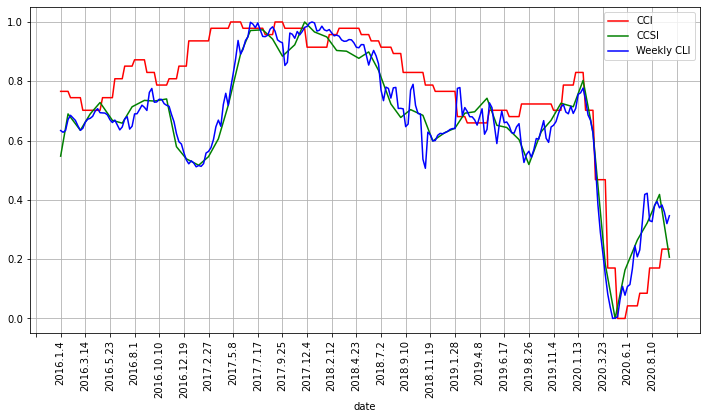

In [97]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(final['date'], final['CCI'], color = 'red', label = 'CCI')
plt.plot(final['date'], final['ccsi'], color = 'green', label = 'CCSI')
plt.plot(final['date'], final['weeklyCLI'], color = 'blue', label = 'Weekly CLI')
plt.xlabel("date")
ax = plt.subplot()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)
plt.grid(True)
plt.legend()
plt.show()